Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Run FLAML in AzureML


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library together with AzureML.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` and `azureml` option:
```bash
pip install flaml[notebook,azureml]
```

In [ ]:
!pip install flaml[notebook,azureml]

### Enable mlflow in AzureML workspace

In [1]:
import mlflow
from azureml.core import Workspace

ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [2]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id = 1169, data_dir = './')

load dataset from ./openml_ds1169.pkl
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [4]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'accuracy', # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "estimator_list": ['lgbm', 'rf', 'xgboost'], # list of ML learners
    "task": 'classification', # task type    
    "sample": False, # whether to subsample training data
    "log_file_name": 'airlines_experiment.log', # flaml log file
}

In [5]:
mlflow.set_experiment("flaml")
with mlflow.start_run() as run:
    '''The main flaml automl API'''
    automl.fit(X_train = X_train, y_train = y_train, **settings)

INFO - Evaluation method: holdout
INFO - Using StratifiedKFold
INFO - Minimizing error metric: 1-accuracy
INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost']
INFO - iteration 0  current learner lgbm
INFO -  at 1.6s,	best lgbm's error=0.3771,	best lgbm's error=0.3771
INFO - iteration 1  current learner lgbm
INFO -  at 4.7s,	best lgbm's error=0.3771,	best lgbm's error=0.3771
INFO - iteration 2  current learner lgbm
INFO -  at 5.6s,	best lgbm's error=0.3751,	best lgbm's error=0.3751
INFO - iteration 3  current learner xgboost
INFO -  at 9.6s,	best xgboost's error=0.3750,	best xgboost's error=0.3750
INFO - iteration 4  current learner lgbm
INFO -  at 12.5s,	best lgbm's error=0.3751,	best xgboost's error=0.3750
INFO - iteration 5  current learner lgbm
INFO -  at 14.3s,	best lgbm's error=0.3558,	best lgbm's error=0.3558
INFO - iteration 6  current learner rf
INFO -  at 22.7s,	best rf's error=0.3876,	best lgbm's error=0.3558
INFO - iteration 7  current learner lgbm
INFO -  at 

### Best model and metric

In [6]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 6.0, 'max_leaves': 1073.0, 'min_child_weight': 5.630999649172112, 'learning_rate': 0.32864729892819683, 'subsample': 1.0, 'log_max_bin': 10.0, 'colsample_bytree': 0.99236562733598, 'reg_alpha': 1.978160373587824e-09, 'reg_lambda': 1.0}
Best accuracy on validation data: 0.6626
Training duration of best run: 2.253 s


In [7]:
automl.model

LGBMClassifier(colsample_bytree=0.99236562733598,
               learning_rate=0.32864729892819683, max_bin=1023,
               min_child_weight=5.630999649172112, n_estimators=6,
               num_leaves=1073, objective='binary',
               reg_alpha=1.978160373587824e-09, reg_lambda=1.0)

In [8]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [9]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [1 0 1 ... 1 0 0]
True labels [0 0 0 ... 0 1 0]


In [10]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))
print('f1', '=', 1 - sklearn_metric_loss_score('f1', y_pred, y_test))

accuracy = 0.6649585453035315
roc_auc = 0.7164009096685227
log_loss = 0.6109261780043986
f1 = 0.5708885406278198


### Log history

In [11]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = settings['log_file_name'], time_budget = 60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 364083, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 364083, 'Current Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.46335414315327306, 'subsample': 0.9339389930838808, 'log_max_bin': 10.0, 'colsample_bytree': 0.9904286645657556, 'reg_alpha': 2.841147337412889e-10, 'reg_lambda': 0.12000833497054482}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.463354143

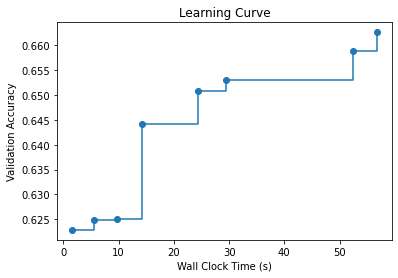

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1-np.array(valid_loss_history))
plt.step(time_history, 1-np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [13]:
''' SKLearnEstimator is the super class for a sklearn learner '''
from flaml.model import SKLearnEstimator
from flaml import tune
from rgf.sklearn import RGFClassifier, RGFRegressor


class MyRegularizedGreedyForest(SKLearnEstimator):


    def __init__(self, task = 'binary:logistic', n_jobs = 1, **params):
        '''Constructor
        
        Args:
            task: A string of the task type, one of
                'binary:logistic', 'multi:softmax', 'regression'
            n_jobs: An integer of the number of parallel threads
            params: A dictionary of the hyperparameter names and values
        '''

        super().__init__(task, **params)

        '''task=regression for RGFRegressor; 
        binary:logistic and multiclass:softmax for RGFClassifier'''
        if 'regression' in task:
            self.estimator_class = RGFRegressor
        else:
            self.estimator_class = RGFClassifier

        # convert to int for integer hyperparameters
        self.params = {
            "n_jobs": n_jobs,
            'max_leaf': int(params['max_leaf']),
            'n_iter': int(params['n_iter']),
            'n_tree_search': int(params['n_tree_search']),
            'opt_interval': int(params['opt_interval']),
            'learning_rate': params['learning_rate'],
            'min_samples_leaf':int(params['min_samples_leaf'])
        }    

    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space

        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain and init_value (optional), cat_hp_cost (optional) 
                e.g., 
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}
        '''
        space = {        
        'max_leaf': {'domain': tune.qloguniform(lower = 4, upper = data_size, q = 1), 'init_value': 4},
        'n_iter': {'domain': tune.qloguniform(lower = 1, upper = data_size, q = 1), 'init_value': 1},
        'n_tree_search': {'domain': tune.qloguniform(lower = 1, upper = 32768, q = 1), 'init_value': 1},
        'opt_interval': {'domain': tune.qloguniform(lower = 1, upper = 10000, q = 1), 'init_value': 100},
        'learning_rate': {'domain': tune.loguniform(lower = 0.01, upper = 20.0)},
        'min_samples_leaf': {'domain': tune.qloguniform(lower = 1, upper = 20, q = 1), 'init_value': 20},
        }
        return space

    @classmethod
    def size(cls, config):
        '''[optional method] memory size of the estimator in bytes
        
        Args:
            config - the dict of the hyperparameter config

        Returns:
            A float of the memory size required by the estimator to train the
            given config
        '''
        max_leaves = int(round(config['max_leaf']))
        n_estimators = int(round(config['n_iter']))
        return (max_leaves*3 + (max_leaves-1)*4 + 1.0)*n_estimators*8

    @classmethod
    def cost_relative2lgbm(cls):
        '''[optional method] relative cost compared to lightgbm
        '''
        return 1.0


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [14]:
automl = AutoML()
automl.add_learner(learner_name = 'RGF', learner_class = MyRegularizedGreedyForest)

In [15]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'], # list of ML learners
    "task": 'classification', # task type    
    "sample": True, # whether to subsample training data
    "log_file_name": 'airlines_experiment_custom.log', # flaml log file
    "log_training_metric": True, # whether to log training metric
}

mlflow.set_experiment("flaml_custom")
with mlflow.start_run() as run:
    '''The main flaml automl API'''
    automl.fit(X_train = X_train, y_train = y_train, **settings)

INFO - Evaluation method: holdout
INFO - Using StratifiedKFold
INFO - Minimizing error metric: 1-accuracy
INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
INFO - iteration 0  current learner RGF
INFO -  at 1.3s,	best RGF's error=0.3787,	best RGF's error=0.3787
INFO - iteration 1  current learner RGF
INFO -  at 4.4s,	best RGF's error=0.3787,	best RGF's error=0.3787
INFO - iteration 2  current learner RGF
INFO -  at 5.3s,	best RGF's error=0.3787,	best RGF's error=0.3787
INFO - iteration 3  current learner lgbm
INFO -  at 5.3s,	best lgbm's error=0.3777,	best lgbm's error=0.3777
INFO - iteration 4  current learner RGF
INFO -  at 8.4s,	best RGF's error=0.3787,	best lgbm's error=0.3777
INFO - iteration 5  current learner lgbm
INFO -  at 8.4s,	best lgbm's error=0.3777,	best lgbm's error=0.3777
INFO - iteration 6  current learner lgbm
INFO -  at 8.5s,	best lgbm's error=0.3669,	best lgbm's error=0.3669
INFO - iteration 7  current learner lgbm
INFO -  at 10.4s,	best lgb